<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

#Загрузим данные и посмотрим информацию о таблице
data_tax = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print('Информация о таблице:\n')
data_tax.info()

Информация о таблице:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

                     num_orders
datetime                       
2018-08-31 22:50:00          34
2018-08-31 23:00:00          30
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53


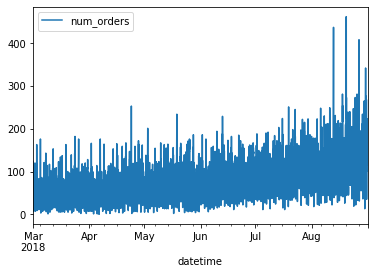

In [2]:
#Отобразим последник строки данных
print(data_tax.tail(7))

#Проведем ресемплирование по 1 часу
data = data_tax.resample('1H').sum()

#Построим график
data.plot()

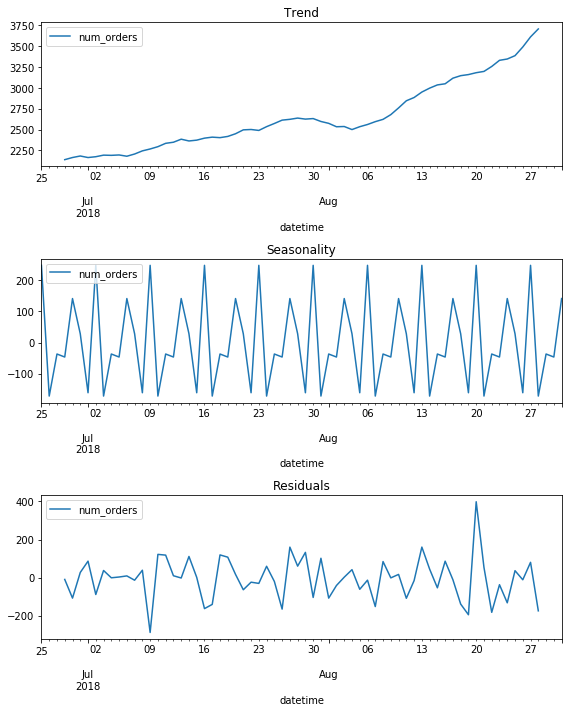

In [3]:
#Посмотрим сезонность, тренд и остаток декомпозиции.

#Выполним сортировку по индексу
data.sort_index(inplace=True)
#Выполним срез данных в промежутке 2018-06-01 : 2018-08-31
data_plot = data_tax['2018-06-25':'2018-08-31'].resample('1D').sum()

#Выполним декомпозицию среза данных в промежутке 2018-06-01 : 2018-08-31
decomposed = seasonal_decompose(data_plot) 

#Построим графики
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

# Вывод:

На графике видна ежедная сезонность, поэтому выберим признак day. Также есть зависимоть от дня неделе, поэтому выберим еще один признак dayofweek. От месяца к месяцу сданные повторяются, поэтому выберем еще признак month. Ширину окна - rolling_mean и lag определим как 24, так как 24 часа в сутках. 

## Обучение

# Создание признаков

In [4]:
#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 24, 24)

#Разделим данные на обучающую и тестовую выборку (тестовая выборка - 10% от общих данных)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# Линейная регрессия. Обучение и подбор параметров.

In [5]:
#Линейная регрессия
#Модель №1
model = LinearRegression()
model.fit(features_train, target_train)
train_pred = model.predict(features_train)
print("Линейная регрессия")
print("RMSE обучающей выборки: ", mean_squared_error(target_train, train_pred)**0.5)

#Модель №2
#Установим параметры normalize и copy_X в значение bool  и обучим модель
model = LinearRegression(normalize = bool, copy_X = bool)
model.fit(features_train, target_train)
train_pred = model.predict(features_train)
print("RMSE обучающей выборки (normalize = bool, copy_X = bool): ", mean_squared_error(target_train, train_pred)**0.5)

Линейная регрессия
RMSE обучающей выборки:  25.818602103995378
RMSE обучающей выборки (normalize = bool, copy_X = bool):  25.818492845101087


# Случайный лес

### Подбор гиперпараметров

In [6]:
#Случайный лес
#Модель №1
best_model = None
best_result = 1000
for est in range(1, 30):
    for depth in range(1,30):
        model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est, min_samples_split=3, min_samples_leaf=1) #установим гиперпараметры
        model.fit(features_train, target_train) # обучим модель на тренировочной выборке
        train_pred = model.predict(features_train)
        result = mean_squared_error(target_train, train_pred)**0.5 # посчитаем accuracy модели на валидационной выборке
        if result < best_result:
            best_model = model
            best_result = result
            
print("Лучшая модели 'случайный лес' на обучающей выборке:\n", best_model)
print("Лучший RMSE модели 'случайный лес' на обучающей выборке:", result)

Лучшая модели 'случайный лес' на обучающей выборке:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=29,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)
Лучший RMSE модели 'случайный лес' на обучающей выборке: 9.698473507803158


### Обучение

In [7]:
#Модель №1
model = RandomForestRegressor(random_state=12345, max_depth=25, n_estimators=29, min_samples_split=3, min_samples_leaf=1)
model.fit(features_train, target_train)
train_pred = model.predict(features_train)
print("\nСлучайный лес")
print("RMSE тестовой выборки(n_estimators=29, max_depth=25): ", mean_squared_error(target_train, train_pred)**0.5)

#Модель №2
model = RandomForestRegressor(random_state=12345, max_depth=30, n_estimators=30, min_samples_split=3, min_samples_leaf=1)
model.fit(features_train, target_train)
train_pred = model.predict(features_train)
print("\nСлучайный лес")
print("RMSE тестовой выборки(n_estimators=30, max_depth=30): ", mean_squared_error(target_train, train_pred)**0.5)


Случайный лес
RMSE тестовой выборки(n_estimators=29, max_depth=25):  9.678522092972916

Случайный лес
RMSE тестовой выборки(n_estimators=30, max_depth=30):  9.680557965569053


# CatBoost

### Подбор гиперпараметров

In [8]:
#Напишем функцию для кросс-валидации временных рядов
def cv_time_series_rmse(regressor, data, target_column, n_splits):
    tscv = TimeSeriesSplit(n_splits = 4)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        features_train_cat = train.drop(target_column, axis=1)
        target_train_cat = train[target_column]
        features_test_cat = test.drop(target_column, axis=1)
        target_test_cat = test[target_column]
        regressor.fit(features_train_cat, target_train_cat)
        RMSE += mean_squared_error(target_test_cat, regressor.predict(features_test_cat)) ** 0.5
    return RMSE / n_splits

#Подберем гипперпараметры
regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[12345],
                'verbose':[False]}]

print('Подбор гиперпараметров:\n')
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие гипперпараметры:\n")
print()
best_params_CBR = clf.best_params_
print(best_params_CBR)
print()
print("Выборка гиперпараметров:\n")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))

Подбор гиперпараметров:



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Лучшие гипперпараметры:


{'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

Выборка гиперпараметров:


25.803038 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
26.904123 for {'learning_rate': 0.2, 'random_state': 12345, 'verbose': False}
26.856077 for {'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}
28.075290 for {'learning_rate': 0.4, 'random_state': 12345, 'verbose': False}
27.522679 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}


### Обучение

In [9]:
regressor = CatBoostRegressor()
regressor.set_params(**best_params_CBR)
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 3
cv_RMSE_CBR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits)
print('RMSE для модели CatBoostRegressor =', cv_RMSE_CBR)

RMSE для модели CatBoostRegressor = 34.38060983175928


## Тестирование

In [10]:
#Модель №1
model = LinearRegression()
model.fit(features_train, target_train)
test_pred = model.predict(features_test)
print("Линейная регрессия")
print("RMSE тестовой выборки: ", mean_squared_error(target_test, test_pred)**0.5)

#Модель №2
model = LinearRegression(normalize = bool, copy_X = bool)
model.fit(features_train, target_train)
test_pred = model.predict(features_test)
print("RMSE тестовой выборки (normalize = bool, copy_X = bool): ", mean_squared_error(target_test, test_pred)**0.5)

#Случайный лес
#Модель №1
model = RandomForestRegressor(random_state=12345, max_depth=25, n_estimators=29, min_samples_split=3, min_samples_leaf=1)
model.fit(features_train, target_train)
test_pred = model.predict(features_test)
print("\nСлучайный лес")
print("RMSE тестовой выборки(max_depth=25, n_estimators=29, min_samples_split=3, min_samples_leaf=1): ", mean_squared_error(target_test, test_pred)**0.5)

#Модель №2
model = RandomForestRegressor(random_state=12345, max_depth=30, n_estimators=30, min_samples_split=3, min_samples_leaf=1)
model.fit(features_train, target_train)
test_pred = model.predict(features_test)
print("RMSE тестовой выборки(max_depth=20, n_estimators=30, min_samples_split=30, min_samples_leaf=1): ", mean_squared_error(target_test, test_pred)**0.5)

#CatBoost
print("\nCatBoostRegressor")
model = CatBoostRegressor()
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5
print("RMSE обучающей выборки('learning_rate': 0.1, 'random_state': 12345, 'verbose': False):", final_RMSE_CBR)

Линейная регрессия
RMSE тестовой выборки:  45.52933708020939
RMSE тестовой выборки (normalize = bool, copy_X = bool):  45.527214642495736

Случайный лес
RMSE тестовой выборки(max_depth=25, n_estimators=29, min_samples_split=3, min_samples_leaf=1):  45.36150194501276
RMSE тестовой выборки(max_depth=20, n_estimators=30, min_samples_split=30, min_samples_leaf=1):  45.30384945368576

CatBoostRegressor
RMSE обучающей выборки('learning_rate': 0.1, 'random_state': 12345, 'verbose': False): 40.597155018785614


# Вывод:

Были исследованы три модели с подобранными признакми, это линейная регрессия, случайный лес и CatBoostRegressor. В качестве призанков были выбраны day, month, dayofweek, year. Ширину окна - rolling_mean и lag определи как 24, так как 24 часа в сутках. 
Все модели показали RMSE меньше 48. Самая лучшая модель - это CatBoost('learning_rate': 0.1, 'random_state': 12345, 'verbose': False): 40.597155018785614. На втором месте случайный лес (max_depth=20, n_estimators=30, min_samples_split=30, min_samples_leaf=1):  45.30384945368576 и на последнем месте линейная регрессия (normalize = bool, copy_X = bool):  45.527214642495736. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48